In [1]:
import argparse
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 12})

In [2]:
def compartment_colors(compartments):
    compartment_color_dict = {comp : col for comp, col in zip(compartments,sns.color_palette("deep",len(compartments)))}

    # ensure same colors for key compartments
    palette = sns.color_palette("deep",4)
    compartment_color_dict["Endothelial"] = palette[0]
    compartment_color_dict["endothelial"] = palette[0]
    compartment_color_dict["Epithelial"] = palette[1]
    compartment_color_dict["epithelial"] = palette[1]
    compartment_color_dict["Immune"] = palette[2]
    compartment_color_dict["immune"] = palette[2]
    compartment_color_dict["Stromal"] = palette[3]
    compartment_color_dict["stromal"] = palette[3]
    return compartment_color_dict


def get_args():
  parser = argparse.ArgumentParser(description="make dotplots per donor")

  parser.add_argument("--params",help="tab separated tsv file with columns 'gene','let', and 'end'")
  parser.add_argument("--datanames",nargs="+",help="data names to run for")
  parser.add_argument("--organism",choices=["lemur","human","mouse"],default="human",help="organism of submitted data")
  parser.add_argument("--subfolder",help="subfolder to save in")
  parser.add_argument("--cell_lim",type=int,default=20,help="number of cells to limit ontologies to")
  parser.add_argument("--FDR_col",default = "",help="column to use to define significant types")

  args = parser.parse_args()
  return args

def annotation_plot(gtf, domains, gene, end,outpath,datanames,zoom=True, plot_all=True):
  rev_dict = {"A" : "B","B" : "A"}

  # gene = "CALD1"
  # end = 134928754
  don_df = pd.read_csv("{}{}/{}_{}_{}_coords.tsv".format(outpath,gene,"_".join(datanames),gene,end),sep="\t")
  don_df = don_df.rename(columns={"rank_acc" : "rank", "rank_don" : "rank"}).astype(int)


  if don_df["juncPosR1A"].nunique() == 1:
    let = "A"
  else:
    let = "B"

  shared_ends = list(don_df["juncPosR1" + rev_dict[let]])

  # for gene in genes:
  gene_gtf = gtf[gtf["gene_id"] == gene]
  gene_gtf = gene_gtf[gene_gtf["feature"].isin(["exon"])]

  legend = True
  name_end = ""

  if don_df["juncPosR1" + rev_dict[let]].nunique() > 1:

    colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf',u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
    someX, someY = 0.5, 0.5
    plt.figure(figsize=(12, 6))
    h = 1
    offset = 1
    currentAxis = plt.gca()
    count = 1
    y_labels = []
    arc_height = 10
    y_ticks = []
    arcs = False
    chromosome = gene_gtf["seqname"].iloc[0]
    gene_min_all = gene_gtf["start"].min()
    gene_max_all = gene_gtf["end"].max()

    legend_elements = []

    gene_domains = domains[(domains[1] == chromosome) & (domains[2] < gene_max_all) & (domains[3] > gene_min_all)]

    # if arcs:
    # count = 1
    if gene_gtf["strand"].iloc[0] == "+":
      asc = True
    else:
      asc = False

  #   plt.text(row["juncPosR1" + rev_dict[let]],gene_gtf["transcript_id"].nunique() + 1,row["rank"],horizontalalignment="center")
    for ind, row in don_df.iterrows():
        if plot_all:
          name_end += "_all"
          plt.text(row["juncPosR1" + rev_dict[let]],gene_gtf["transcript_id"].nunique() + 1,row["rank"],horizontalalignment="center")
          plt.plot([row["juncPosR1" + rev_dict[let]],row["juncPosR1" + rev_dict[let]]],[ -0.5,gene_gtf["transcript_id"].nunique() + 0.5],color="red")
    plt.plot([row["juncPosR1" + let],row["juncPosR1" + let]],[ -0.5,gene_gtf["transcript_id"].nunique() + 0.5],color="blue")


    count = 0
    for transcript, trans_df in gene_gtf.groupby("transcript_id"):
      y_labels.append(transcript)
      y_ticks.append(count * offset)
      gene_min = trans_df["start"].min()
      gene_max = trans_df["end"].max()
      plt.plot([gene_min,gene_max],[offset * count,offset * count],color="k")

      for exons in set([tuple(x) for x in trans_df[["start","end"]].to_numpy()]):
        plot_exon(exons,currentAxis,offset = count * offset)
      i = 0
      for d in set([tuple(x) for x in gene_domains[[2,3,4]].to_numpy()]):
        plot_exon(d[:2],currentAxis,offset = count * offset,alpha = 0.4,color=colors[i],ecolor=None,h=0.5)
        legend_elements.append(Patch(facecolor=colors[i], edgecolor=None,label=d[2],alpha=0.4))
        i += 1

      count += 1

    if arcs:
      plt.ylim([-1,gene_gtf["transcript_id"].nunique() + arc_height + 1])
    else:
      plt.ylim([-1,gene_gtf["transcript_id"].nunique() + 2])

    currentAxis.ticklabel_format(useOffset=False,style="plain")
    if legend:
      currentAxis.legend(handles=legend_elements[:gene_domains.shape[0]],bbox_to_anchor=(1., 1.0))
    plt.yticks(y_ticks,y_labels)
  #   plt.xlim([gene_min_all,gene_max_all])
    if zoom:
      print("shared_ends",shared_ends,"end",end)
      buff = max([abs(int(x) - int(end)) for x in shared_ends])/12
      plt.xlim(min([int(end)] + shared_ends) - buff,max([int(end)] + shared_ends) + buff)
      name_end += "_zoom"
    else:
      plt.xlim([gene_min_all,gene_max_all])

    plt.title("{} {} {}".format(gene,chromosome,end))
#     try:
    plt.show()
    plt.savefig("{}{}/{}_{}_{}_don_ann{}.png".format(outpath,gene,"_".join(datanames),gene,end, name_end),bbox_inches = "tight")
    plt.close()
#     except Exception as e:
#       print(e)

def plot_exon(locs,ax,h=0.25,offset = 0,bin_size=400,alpha=1,color="k",ecolor="k"):
#   print("plotting exon")
  ax.add_patch(Rectangle((locs[0], -h + offset), locs[1] - locs[0], 2*h,edgecolor=ecolor,color=color,alpha=alpha,linewidth=0))
  
def load_gtf(gtf_file,filt_chr):
  gtf = pd.read_csv(gtf_file, names = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"], sep="\t")
  if 'NC_000023.11' in gtf["seqname"].unique():
    can_chrom = [x for x in gtf["seqname"].unique() if x.startswith("NC_")]
    name_dict = {x : "chr" + str(int(x.split("_")[1].split(".")[0])) for x in can_chrom}
    name_dict['NC_000023.11'] = "chrX"
    name_dict['NC_000024.10'] = "chrY"
    name_dict['NC_012920.1'] = "chrM"
    gtf["seqname"] = gtf["seqname"].map(name_dict)
    gtf = gtf[~gtf["seqname"].isna()]
    filt_chr = False
  #   gtf = gtf[gtf["feature"] == "exon"]
  try:
    gtf["gene_id"] = gtf["attribute"].str.split("gene_name").str[1].str.split(";").str[0].str.split('"').str[1]
  except:
    gtf["gene_id"] = gtf["attribute"].str.split("gene_id").str[1].str.split(";").str[0].str.split('"').str[1]
  gtf["transcript_id"] = gtf["attribute"].str.split("transcript_id").str[1].str.split(";").str[0].str.split('"').str[1]
#  filt_chr = True
  if filt_chr:
    # don't include immature scaffolds
    chromosomes = gtf["seqname"].unique()
    chromosomes = [x for x in chromosomes if "_" not in x and not x.startswith("KN")]
#    print("chromosomes",chromosomes)
    gtf = gtf[gtf["seqname"].isin(chromosomes)]
  gtf["chr_gene"] = gtf["seqname"] + gtf["gene_id"]
  return gtf


def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
#              'Fat': '#e7cb94',
#              'Heart': '#637939',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Skin': '#ce6dbd',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Trachea': '#969696',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict

def test_forward(array):
  
  return [float(x) / 2 for x in array]

def test_backward(array):
  return [x * 2 for x in array]

def dot_plot(don_df, let, let_dict, palette, onts, outpath, gene, don, tiss, dataname, rev_dict):
  expand_dict = {"don" : "3 prime end","acc" : "5 prime end"}
#  print("in dot")
  print("a")
  don_df["ontology_rank"] = don_df["ontology"] + don_df["rank_" + let_dict[let]].astype(str)
  don_df["rank_count"] = don_df["ontology_rank"].map(don_df.groupby("ontology_rank")["numReads"].sum())
  ont_dict = {o : i for o, i in zip(onts,range(1,don_df["ontology"].nunique() + 1))}
  don_df["ont_num"] = don_df["ontology"].map(ont_dict)
  pdf = don_df.drop_duplicates("ontology_rank")
  pdf["rank_sum"] = pdf["ontology"].map(pdf.groupby("ontology")["rank_count"].sum())
  pdf["frac_rank"] = pdf["rank_count"] / pdf["rank_sum"]
#  pdf["rank_sum"] = pdf["ontology"].map(pdf.groupby("ontology")["scaled_rank"].sum())
#  pdf["scaled_rank"] = pdf["scaled_rank"] / pdf["rank_sum"]
  print("b")
  sns.relplot(x="rank_" + let_dict[let], y="ont_num", size="frac_rank",
              sizes=(10, 400), alpha=.5, palette=palette,hue="compartment",
              height=max(4,pdf["ontology"].nunique()*0.3), data=pdf).set_axis_labels(expand_dict[let_dict[let]] + "s","")

#     onts = []
#     vals = []
#     for key, value in ont_dict.items():
#       onts.append(key)
#       vals.append(value)
  print("onts",onts)
#   plt.yticks(range(1,don_df["ontology"].nunique() + 1),onts)
  plt.title("{}\n{} {} {} {}".format(dataname,gene,tiss, don, let_dict[rev_dict[let]]))
#   plt.savefig("{}{}_{}_{}_{}_{}_dot.png".format(outpath, gene, don, tiss, dataname, let_dict[rev_dict[let]]),bbox_inches="tight")
#  print("saved")
  plt.close()
  print("c")
  return 0

def plot_df(df, let, cell_lim, outpath, gene, dataname, let_dict, palette, rev_dict, don,tiss, don_df, comp_sort):
#    df["num_cells"] = df["ontology"].map(df.groupby("ontology")["cell"].nunique())
#
#    df = df[df["num_cells"] > cell_lim]

    # calculate ontology-wide values to sort on
    df["ont_rank"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].median())
    df["ont_75"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].quantile(0.75))
    df["ont_25"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].quantile(0.25))

    df["ont_max"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].max())
    df["ont_min"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].min())
    df = df.sort_values(["ont_rank","ont_75","ont_25","ont_max","ont_min"])

    num_cells = list(df.drop_duplicates("ontology")["num_cells"])
    medians = list(df.drop_duplicates("ontology")["ont_rank"])
    if df.shape[0] > 0:
      fig,(ax2) = plt.subplots(1)
      g = sns.boxplot(x="avg_rank", y="ontology",hue="compartment",dodge=False,
                       data=df,
                       orient="h", palette=palette)
#       g = sns.violinplot(x="avg_rank", y="ontology",hue="compartment",dodge=False,
#                        data=df,
#                        orient="h", palette=palette)
      for i,artist in enumerate(ax2.artists):
          # Set the linecolor on the artist to the facecolor, and set the facecolor to None
          col = artist.get_facecolor()
          artist.set_edgecolor(col)
          artist.set_facecolor('None')

          # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
          # Loop over them here, and use the same colour as above
          for j in range(i*6,i*6+6):
              line = ax2.lines[j]
              line.set_color(col)
              line.set_mfc(col)
              line.set_mec(col)

      # Also fix the legend
      for legpatch in ax2.get_legend().get_patches():
          col = legpatch.get_facecolor()
          legpatch.set_edgecolor(col)
          legpatch.set_linewidth(10)
          legpatch.set_facecolor('None')
#         medians = df.groupby("ontology")["avg_rank"].median()
      for i in range(len(num_cells)):
        plt.text(df["avg_rank"].max() + (df["avg_rank"].max() - df["avg_rank"].min())/12,i, num_cells[i])


        plt.scatter([medians[i]],[i],color = "k",s=20,zorder=100)
      plt.title("{}\n{} {} {} {}\nmean: {:0.2f} median: {:0.2f}".format(dataname,gene,tiss, don, let_dict[rev_dict[let]], don_df["avg_rank"].mean(), don_df["avg_rank"].median()))
      plt.legend(bbox_to_anchor=(1.5, 1.05))
#       plt.savefig("{}{}_{}_{}_{}_{}.png".format(outpath, gene, don, tiss, dataname, let_dict[rev_dict[let]]),bbox_inches="tight")
      plt.close()
      return df

def box(df, let, cell_lim, outpath, gene, dataname, let_dict, palette, rev_dict, comp_sort):

  for don, don_df in df.groupby("pos{}_group".format(let)):
    temp = plot_df(don_df.drop_duplicates("pos{}_cell".format(let)), let, cell_lim, outpath, gene, dataname, let_dict, palette, rev_dict, don,"all", don_df, comp_sort)
    if not temp is None:
      if temp["ontology"].nunique() > 0:
        onts = list(temp.sort_values(["ont_rank","ont_75","ont_25","ont_max","ont_min"]).drop_duplicates("ontology")["ontology"].unique())

        onts.reverse()
        response = dot_plot(don_df, let, let_dict, palette,onts, outpath, gene, don, "all", dataname, rev_dict)
    for tiss, tiss_df in don_df.groupby("tissue"):
      temp = plot_df_vioin(tiss_df.drop_duplicates("pos{}_cell".format(let)), let, cell_lim, outpath, gene, dataname, let_dict, palette, rev_dict, don,tiss, don_df)
      if not temp is None:
        if temp["ontology"].nunique() > 0:
          onts = list(temp.sort_values(["ont_rank","ont_75","ont_25","ont_max","ont_min"]).drop_duplicates("ontology")["ontology"].unique())

          onts.reverse()
          response = dot_plot(tiss_df, let, let_dict, palette,onts,outpath, gene, don, tiss, dataname, rev_dict)
          if type(response) != int:
            print("ERROR")
            return response

In [13]:
expand_dict = {"don" : "3 prime end","acc" : "5 prime end"}

plot_ss2_missed = False

organism = "lemur"

if organism == "human":
  # params = "/oak/stanford/groups/horence/Roozbeh/single_cell_project/processed_files/zscores/PCA/driver_sites/TSP2_10x.tsv"
  datanames = ["TSP2_10x_rerun_with_postprocessing_3prime_cellann","TSP1_10x_with_postprocessing_nopanc_cellann","TSP2_SS2_RUN1_RUN2_cellann","TS_pilot_smartseq_with_postprocessing_nopanc_cellann"]

elif organism == "mouse":
#   params = "/oak/stanford/groups/horence/Roozbeh/single_cell_project/processed_files/zscores/PCA/driver_sites/Tabula_muris_senis_P1_10x.tsv" 
  datanames = ["Tabula_muris_senis_P1_10x_with_postprocessing_cellann","Tabula_muris_senis_P2_10x_with_postprocessing_cellann"]

elif organism == "lemur":
  # params = "/oak/stanford/groups/horence/Roozbeh/single_cell_project/processed_files/zscores/PCA/driver_sites/Lemur_10x_Antoine.tsv" 
  datanames = ["Lemur_10x_Antoine_with_postprocessing_cellann","Lemur_10x_Stumpy_with_postprocessing_cellann"]

# subfolder = "first_evec"
cell_lim = 0


if plot_ss2_missed:
  ss2_missed = ["Proximal Ciliated","Proximal Basal","Proliferating Basal","Mucous","Serous",
        "Capillary Intermediate 2","Bronchial Vessel 1","Bronchial Vessel 2","Lipofibroblast",
        "Mesothelial","CD8+ Memory/Effector T","CD4+ Memory/Effector T","Neutrophil","Mast Cell/Basophil Type 2",
       "Platelet/Megakaryocyte","Macrophage","Proliferating Macrophage","Myeloid Dendritic Type 1","EREG+ Dendritic",
       "TREM2+ Dendritic","Classical Monocyte","OLR1+ Classical Monocyte"]
else:
  ss2_missed = []

outpath = "output/finalize_dotplots/"
plot_domains = True
if plot_domains:
  domains = pd.read_csv("../utility_files/ucscGenePfam.txt",sep="\t",header=None)
else:
  domains = pd.DataFrame(columns=[1,2,3,4,5,6,7])

dataname_dict = {"HLCA4_P2_10x_with_postprocessing_lung" : "HLCA individual 1", "HLCA4_P3_10x_with_postprocessing_lung" : "HLCA individual 2"}
# load gtf
# gtf_file = "/scratch/PI/horence/JuliaO/single_cell/STAR_wrapper/gtf_files/hg38.ncbiRefSeq.gtf" 
# gtf_file = "/oak/stanford/groups/horence/circularRNApipeline_Cluster/index/hg38_genes.gtf"
if organism == "human":
#    gtf_file = "/oak/stanford/groups/horence/Roozbeh/single_cell_project/utility_files/GRCh38_latest_genomic.gtf"
  gtf_file = "../utility_files/grch38_known_genes.gtf"
elif organism == "lemur":
  gtf_file = "../utility_files/ref_Mmur_3.0.gtf"
elif organism == "mouse":
  gtf_file = "../utility_files/GCF_000001635.26_GRCm38.p6_genomic.gtf"


gtf = load_gtf(gtf_file,False)
print("gtf",gtf.head())
sig_color = False
comp_sort = True
#  gtf["gene_id"] = gtf["gene_id"].replace("FYB1","FYB")
#  gtf["gene_id"] = gtf["gene_id"].replace("ATP5F1C","ATP5C1")


#  datanames = ["TS_10x_redo","TSP2_10x_rerun_3prime","TSP1_SS2"]
#  datanames = ["TSP1_10x_nopanc_with_postprocessing","TSP2_10x_3prime_with_postprocessing","TSP1_SS2"]
#  datanames = ["TSP1_10x_nopanc_with_postprocessing","TSP2_10x_3prime_with_postprocessing","TS_pilot_smartseq_with_postprocessing_nopanc_cellann","TSP2_SS2_RUN1_RUN2_cellann"]
#  datanames = ["TSP1_10x_nopanc_with_postprocessing","TSP2_10x_3prime_with_postprocessing"]
#  datanames = ["Tabula_muris_senis_P1_10x_with_postprocessing","Tabula_muris_senis_P2_10x_with_postprocessing"]

#  datanames = ["HLCA4_P2_10x_with_postprocessing_lung","HLCA4_P3_10x_with_postprocessing_lung"]
#  datanames = ["TSP2_10x_rerun_with_postprocessing_3prime_cellann", "TSP1_10x_with_postprocessing_nopanc_cellann","TS_pilot_smartseq_with_postprocessing_nopanc_cellann","TSP2_SS2_RUN1_RUN2_cellann"]
#  datanames = ["TSP2_10x_rerun_with_postprocessing_3prime_cellann", "TSP1_10x_with_postprocessing_nopanc_cellann","TSP2_SS2_RUN1_RUN2_cellann"]


if sig_color: 
  if datanames[0].startswith("HLCA"):
    FDR_col = "FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung"
  elif datanames[0].startswith("TSP"):
    FDR_col = "FDR_TSP1_10x_nopanc_with_postprocessing_TSP2_10x_3prime_with_postprocessing"

sig_onts = defaultdict(lambda : set())
if sig_color:
  for dataname in datanames[:2]:
#      sig = pd.read_csv("/scratch/PI/horence/JuliaO/single_cell/Differential_Splicing/scripts/output/final_FDRs_mz/{}_FDR_S_0.1_z_0.0_b_5_scZ.tsv".format(dataname),sep="\t")
    sig = pd.read_csv("/scratch/PI/horence/JuliaO/single_cell/Differential_Splicing/scripts/output/perm_pvals/{}_fdr_100.tsv".format(dataname),sep="\t")


    sig = sig[sig[FDR_col] < 0.1] 
    for g, gene_df in sig.groupby("geneR1A_uniq"):
      sig_onts[g] = set.union(sig_onts[g],set(gene_df["ontology"]))

# datanames = ["TS_10x_redo","TSP2_10x_rerun_3prime"]
df_dict = {}
gene = "all"
all_compartments = set()
for dataname in datanames:
#   dataname = "TS_10x_redo"
  df = pd.read_parquet("../data/{}_sym_SVD_normdonor_S_0.1_z_0.0_b_5.pq".format(dataname),columns=["tissue","compartment","free_annotation","geneR1A_uniq","posA_group","posB_group","cell", "juncPosR1A", "juncPosR1B", "numReads","sign", "splice_ann"])
  # make compartment labels the same for lemur
  df["compartment"] = df["compartment"].replace("lymphoid","Immune")
  df["compartment"] = df["compartment"].replace("myeloid","Immune")
  df["compartment"] = df["compartment"].replace("megakaryocyte-erythroid","Immune")
  df["compartment"] = df["compartment"].replace("stromal","Stromal")
  df["compartment"] = df["compartment"].replace("epithelial","Epithelial")
  df["compartment"] = df["compartment"].replace("endothelial","Endothelial")
  df["compartment"] = df["compartment"].replace("immune","Immune")
  compartments = sorted([x for x in list(df["compartment"].unique()) if x != None])
  all_compartments.update(compartments)


#    outpath = "/scratch/PI/horence/JuliaO/single_cell/Differential_Splicing/scripts/output/donor_boxplots/"
  if gene != "all":
    df = df[df["geneR1A_uniq"] == gene]
#      df = df[df["juncPosR1B"].isin([56161387,56160626])]
    df = df[df["juncPosR1B"].isin([108047292])]

  # only include ontology/gene pairs with at least 20 cells
#    cell_lim = 20
  df["ontology"] = df["tissue"] + df["compartment"] + df["free_annotation"]
  df["ontology1"] = df["compartment"] + df["tissue"] +  df["free_annotation"]
  df["ontology2"] = df["free_annotation"]

  df["ontology_gene"] = df["ontology"] + df["geneR1A_uniq"]
  df["ontology_don"] = df["ontology"] + df["posA_group"]
  df["ontology_acc"] = df["ontology"] + df["posB_group"]
  df["num_cells"] = df["ontology_gene"].map(df.groupby("ontology_gene")["cell"].nunique())

  df = df[df["num_cells"] > cell_lim]
  df["num_cell_ont"] = df["ontology_gene"].map(df.groupby("ontology_gene")["cell"].nunique())
  df = df[df["num_cell_ont"] > cell_lim]
  print(dataname,df.shape)
  df_dict[dataname] = df
#    print("df shape",df.shape)
#  print("keys",df_dict.keys())
palette = compartment_colors(list(all_compartments))

#  df["ontology"] = df["compartment"] + " " + df["tissue"] + " " + df["free_annotation"]
let_dict = {"A" : "acc", "B" : "don"}
rev_dict = {"A" : "B", "B" : "A"}

# param_df = pd.read_csv(params,sep="\t")

#  param_df = pd.DataFrame.from_dict({"gene" : ["MYL6"], "let" : ["A"], "end" : ["56160320"]})
#  param_df = pd.DataFrame.from_dict({"gene" : ["COMMD6","COMMD6"], "let" : ["A","B"], "end" : [75530311,75530311]})


# print("param_df",param_df) 

gtf        seqname  source feature  start   end score strand frame  \
0  NC_028718.1  RefSeq    exon      1    70     .      +     .   
1  NC_028718.1  RefSeq    exon     71  1045     .      +     .   
2  NC_028718.1  RefSeq    exon   1046  1114     .      +     .   
3  NC_028718.1  RefSeq    exon   1115  2699     .      +     .   
4  NC_028718.1  RefSeq    exon   2700  2774     .      +     .   

                                           attribute     gene_id  \
0  transcript_id "rna74668"; gene_id "gene31927";...  AU129_gt01   
1  transcript_id "rna74669"; gene_id "gene31928";...  AU129_gr02   
2  transcript_id "rna74670"; gene_id "gene31929";...  AU129_gt02   
3  transcript_id "rna74671"; gene_id "gene31930";...  AU129_gr01   
4  transcript_id "rna74672"; gene_id "gene31931";...  AU129_gt03   

  transcript_id               chr_gene  
0      rna74668  NC_028718.1AU129_gt01  
1      rna74669  NC_028718.1AU129_gr02  
2      rna74670  NC_028718.1AU129_gt02  
3      rna74671  NC_028718

In [14]:
if organism == "human":
  # human
  param_df = pd.DataFrame.from_dict({"gene" : ["TPM1", "MYL6"], "let" : ["B","A"], "end" : [63056985,56160320]})

elif organism == "mouse":
  # mouse
  param_df = pd.DataFrame.from_dict({"gene" : ["Tpm1", "Myl6"], "let" : ["A","A"], "end" : [67031029,128492059]})

elif organism == "lemur":
  # lemur
  param_df = pd.DataFrame.from_dict({"gene" : ["TPM1", "MYL6"], "let" : ["B","A"], "end" : [102211637,80950153]})


In [15]:
param_df

,gene,let,end
0,TPM1,B,102211637
1,MYL6,A,80950153


0it [00:00, ?it/s]

gene TPM1
Lemur_10x_Antoine_with_postprocessing_cellann
gene df 1 Lemur_10x_Antoine_with_postprocessing_cellann 102211637 615
Lemur_10x_Stumpy_with_postprocessing_cellann
gene df 1 Lemur_10x_Stumpy_with_postprocessing_cellann 102211637 651
A
B
E
A
B
E
len ont list 2
F
4
ont_list [{'KidneyStromalmyofibroblast cell', 'PancreasEndotheliallymphatic cell (CCL21+)', 'Hypothalamus_PituitaryStromalvascular associated smooth muscle cell', 'KidneyStromalvascular associated smooth muscle cell', 'KidneyEpithelialloop of Henle thin ascending limb epithelial cell', 'ColonEpithelialenterocyte', 'TongueStromalfast muscle cell', 'BoneImmunemegakaryocyte progenitor cell', 'Boneneuralnon-myelinating Schwann cell', 'BladderStromalmyofibroblast cell', 'LungStromalalveolar fibroblast', 'LiverEpithelialcholangiocyte', 'KidneyEndothelialvasa recta descending limb cell (MGP+)', 'BrainEndothelialcapillary cell (FABP4- RBP7-)', 'LungStromalpericyte cell', 'Eye_retinaneuralrod cell', 'BoneStromalunknown_Bone_stro

onts {'KidneyStromalmyofibroblast cell', 'KidneyStromalvascular associated smooth muscle cell', 'KidneyEpithelialloop of Henle thin ascending limb epithelial cell', 'BladderEndothelialartery cell', 'FatStromalpericyte cell', 'TongueEpithelialsuprabasal cell (WIF1+)', 'Small_intestineStromalsmooth muscle cell', 'BladderStromalvascular associated smooth muscle cell', 'BrainEndothelialcapillary cell (FABP4- RBP7-)', 'KidneyEpithelialpodocyte', 'BrainStromalvascular associated smooth muscle cell', 'TracheaEpithelialrespiratory basal cell', 'BrainImmunemacrophage (microglial cell)', 'KidneyEpithelialloop of Henle thin descending limb epithelial cell', 'FatStromalvascular associated smooth muscle cell', 'TracheaEpithelialsecretory cell', 'BrainStromalleptomeningeal cell', 'BladderStromalfibroblast'}
c
C
D
Lemur_10x_Antoine_with_postprocessing_cellann
ont_dict 1 {'Small_intestineStromalpericyte cell': 1, 'Small_intestineStromalsmooth muscle cell': 2, 'DiaphragmEndothelialcapillary cell (FABP4

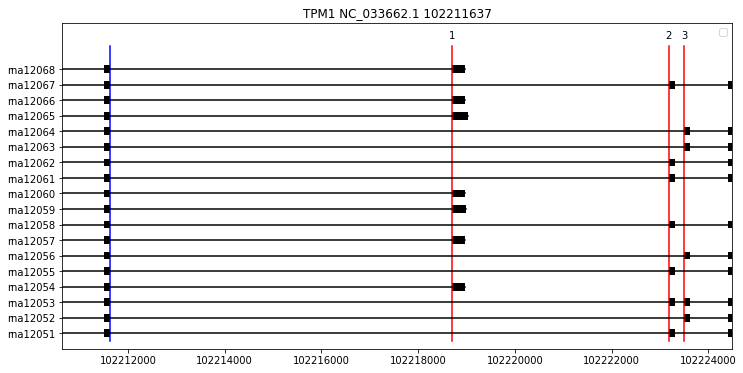

shared_ends [102218692, 102223180, 102223501] end 102211637


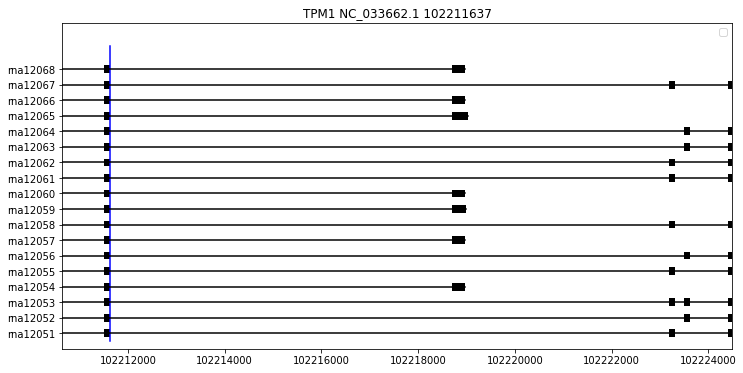

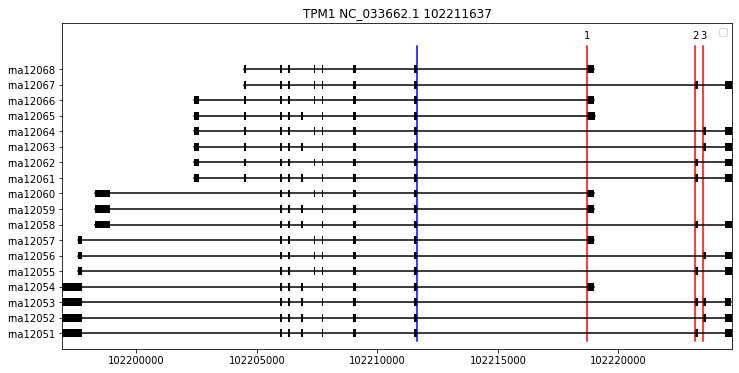

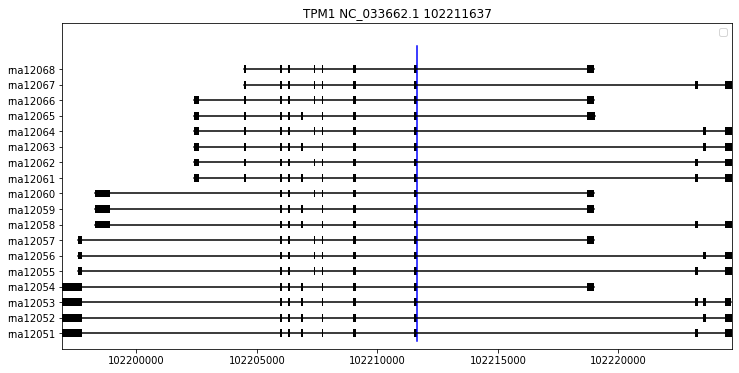

before relplot


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

output/finalize_dotplots/TPM1_Lemur_10x_Antoine_with_postprocessing_cellann_Lemur_10x_Stumpy_with_postprocessing_cellann_102211637.png


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


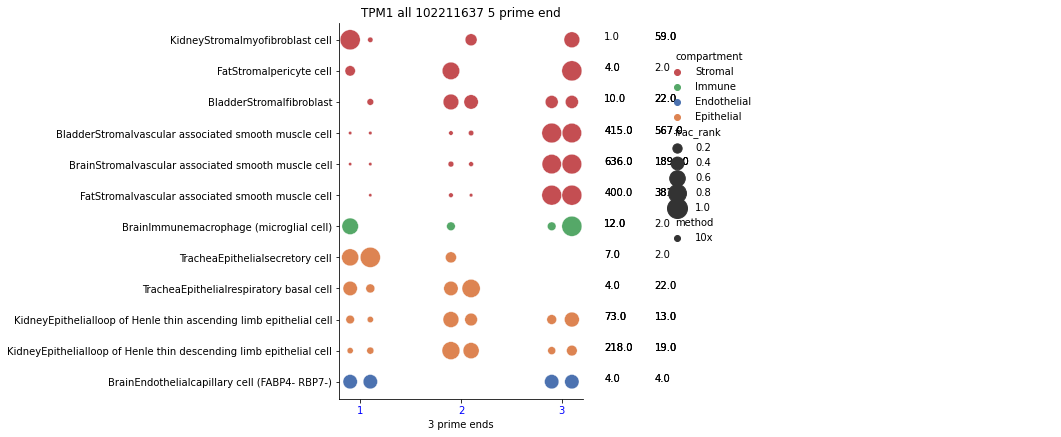

1it [00:14, 14.15s/it]

gene MYL6
Lemur_10x_Antoine_with_postprocessing_cellann
gene df 1 Lemur_10x_Antoine_with_postprocessing_cellann 80950153 60098
Lemur_10x_Stumpy_with_postprocessing_cellann
gene df 1 Lemur_10x_Stumpy_with_postprocessing_cellann 80950153 60443
A
B
E
A
B
E
len ont list 2
F
4
ont_list [{'Bone_marrowImmuneerythroid lineage cell', 'KidneyStromalvascular associated smooth muscle cell', 'KidneyEpithelialalpha-intercalated cell', 'KidneyEndothelialvasa recta ascending limb cell (IGF1+)', 'SpleenImmunenatural killer T cell', 'ColonEpithelialenterocyte_goblet cell', 'FatImmuneneutrophil', 'Small_intestineStromalsmooth muscle cell', 'LiverImmunemacrophage (Kupffer cell MS4A7+)', 'FatImmunemacrophage (MRC1+)', 'LungImmuneinterstitial macrophage', 'KidneyEndothelialcapillary cell (FABP4+ RBP7+)', 'BoneImmuneB cell (PF)', 'BoneImmuneerythroid lineage cell', 'Bone_marrowImmunegranulocyte monocyte progenitor cell', 'Hypothalamus_PituitaryImmunemacrophage (microglial cell)', 'LungStromalairway associate

b
onts {'FatImmunemacrophage (PF)', 'BoneImmuneT cell (CD4- CD8+ CCL5+)', 'KidneyEpithelialurothelial cell', 'KidneyStromalvascular associated smooth muscle cell', 'LungImmunenatural killer cell (GZMB+)', 'LungEndotheliallymphatic cell (CCL21+)', 'Brainneuralastrocyte (SLC7A10+)', 'LiverImmunemonocyte', 'KidneyEpithelialalpha-intercalated cell', 'LiverEndothelialendothelial cell', 'SkinEpithelialinner bulge cell', 'KidneyEndothelialvasa recta ascending limb cell (IGF1+)', 'SpleenImmunenatural killer T cell', 'ColonEpithelialenterocyte_goblet cell', 'FatImmuneneutrophil', 'BladderImmunemature dendritic cell', 'LungImmunealveolar macrophage (LPL+)', 'KidneyEpithelialdistal convoluted tubule epithelial cell', 'Small_intestineImmuneT cell (CD4+ CD8- CCL5-)', 'BladderEndothelialartery cell', 'Bone_marrowImmuneerythroid lineage cell (PF)', 'FatImmunemacrophage (MRC1+)', 'LiverImmunemacrophage (Kupffer cell MS4A7+)', 'Small_intestineStromalsmooth muscle cell', 'SkinEpithelialinterfollicular b

onts {'FatImmunemacrophage (PF)', 'BoneImmuneT cell (CD4- CD8+ CCL5+)', 'KidneyEpithelialurothelial cell', 'KidneyStromalvascular associated smooth muscle cell', 'LungImmunenatural killer cell (GZMB+)', 'LungEndotheliallymphatic cell (CCL21+)', 'Brainneuralastrocyte (SLC7A10+)', 'LiverImmunemonocyte', 'KidneyEpithelialalpha-intercalated cell', 'LiverEndothelialendothelial cell', 'SkinEpithelialinner bulge cell', 'KidneyEndothelialvasa recta ascending limb cell (IGF1+)', 'SpleenImmunenatural killer T cell', 'ColonEpithelialenterocyte_goblet cell', 'FatImmuneneutrophil', 'BladderImmunemature dendritic cell', 'LungImmunealveolar macrophage (LPL+)', 'KidneyEpithelialdistal convoluted tubule epithelial cell', 'Small_intestineImmuneT cell (CD4+ CD8- CCL5-)', 'BladderEndothelialartery cell', 'Bone_marrowImmuneerythroid lineage cell (PF)', 'FatImmunemacrophage (MRC1+)', 'LiverImmunemacrophage (Kupffer cell MS4A7+)', 'Small_intestineStromalsmooth muscle cell', 'SkinEpithelialinterfollicular bas

ont_dict 1 {'DiaphragmStromalskeletal muscle satellite stem cell': 1, 'LungEpithelialtuft cell': 2, 'Brainneuralastrocyte (SLC7A10+)': 3, 'Brainneuralglutamatergic neuron (NEFH+)': 4, 'TracheaStromalchondrocyte': 5, 'Brainneuralependymal cell (NPY+)': 6, 'Brainneuralmyelinating Schwann cell': 7, 'FatEpithelialgranulosa cell': 8, 'Brainneuralastrocyte (LHX2+)': 9, 'SkinEpithelialchannel cell (MMP7+)': 10, 'Limb_muscleStromaltendon cell': 11, 'Brainneuralneuron (LQ)': 12, 'Brainneuralglutamatergic neuron (CBLN1+)': 13, 'Brainneuraloligodendrocyte': 14, 'Brainneuralnon-myelinating Schwann cell': 15, 'TracheaEpithelialtuft cell': 16, 'Fatneuralnon-myelinating Schwann cell': 17, 'Small_intestineneuralnon-myelinating Schwann cell': 18, 'Small_intestineStromalinterstitial cell of Cajal': 19, 'BrainStromalleptomeningeal cell': 20, 'Brainneuralglutamatergic neuron (OTX2+ ROM1+)': 21, 'Brainneuraloligodendrocyte precursor cell': 22, 'BrainneuralGABAergic neuron (OTX2+)': 23, 'BoneStromalosteobla

in dot
found shared ends
ont_dict 2 {'neuralSmall_intestinenon-myelinating Schwann cell': 1, 'neuralFatnon-myelinating Schwann cell': 2, 'neuralBrainoligodendrocyte precursor cell': 3, 'neuralBrainoligodendrocyte': 4, 'neuralBrainneuron (LQ)': 5, 'neuralBrainglutamatergic neuron (CBLN1+)': 6, 'neuralBrainependymal cell': 7, 'neuralBrainchoroid plexus epithelial cell': 8, 'neuralBrainastrocyte (SLC7A10+)': 9, 'neuralBrainastrocyte (LHX2+)': 10, 'neuralBrainGABAergic neuron (OTX2+)': 11, 'hematopoieticSpleenhematopoietic precursor cell': 12, 'hematopoieticBonehematopoietic precursor cell': 13, 'hematopoieticBone_marrowhematopoietic precursor cell': 14, 'StromalTracheafibroblast': 15, 'StromalTracheachondrocyte': 16, 'StromalTonguefibroblast (WIF1+)': 17, 'StromalSmall_intestinevascular associated smooth muscle cell': 18, 'StromalSmall_intestinesmooth muscle cell': 19, 'StromalSmall_intestinemesothelial cell': 20, 'StromalSmall_intestinefibroblast (KCNN3+)': 21, 'StromalSmall_intestinefib

dataname 2
ann_dict {1.0: True, 6.0: True, 3.0: False, 4.0: False, 2.0: False, 1.2: True, 6.2: True, 4.2: False, 3.2: False, 2.2: False}
wrote coords here output/finalize_dotplots/MYL6/Lemur_10x_Antoine_with_postprocessing_cellann_Lemur_10x_Stumpy_with_postprocessing_cellann_MYL6_80950153_coords.tsv
shared_ends [80949088, 80949131, 80949161, 80949169, 80949840] end 80950153


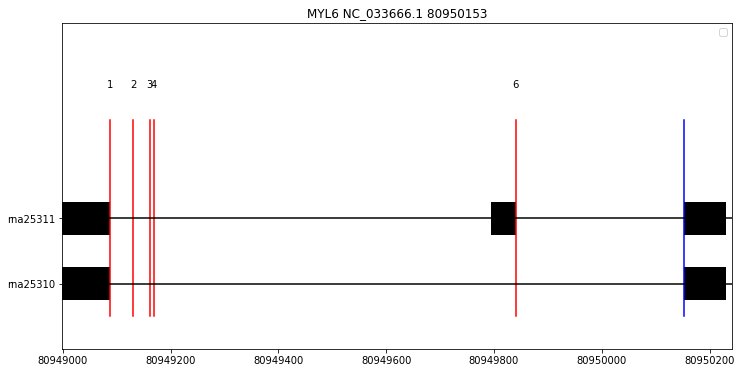

shared_ends [80949088, 80949131, 80949161, 80949169, 80949840] end 80950153


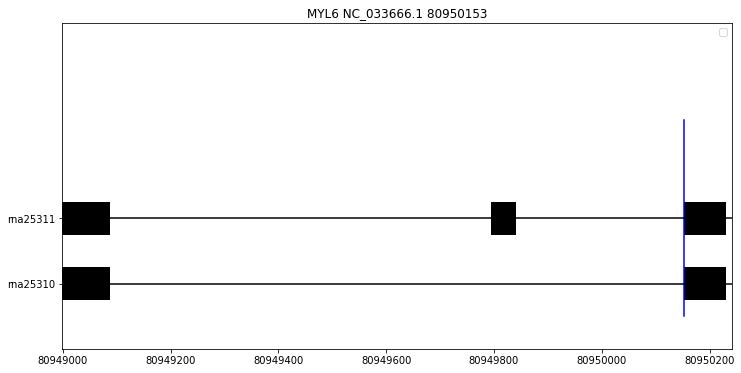

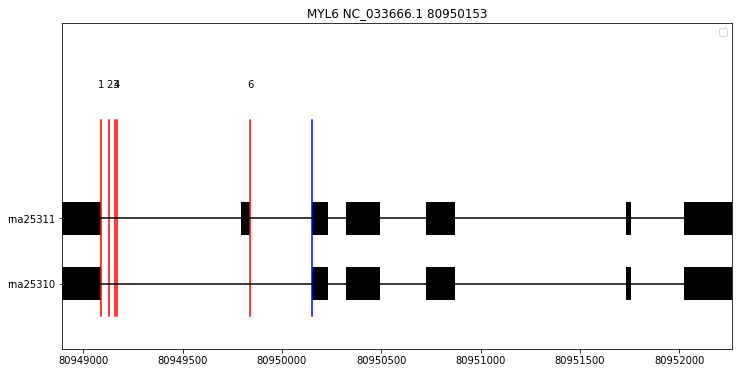

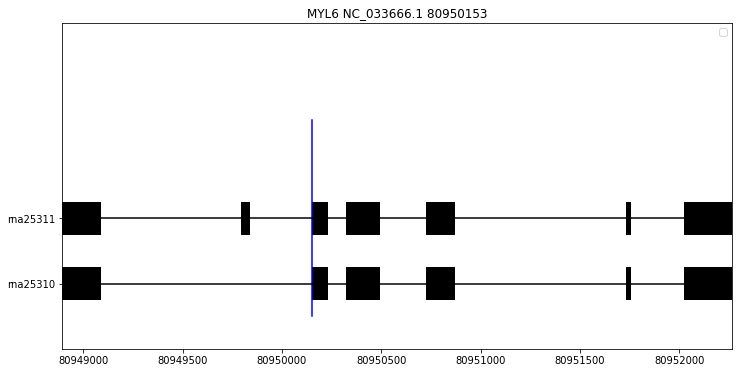

before relplot
output/finalize_dotplots/MYL6_Lemur_10x_Antoine_with_postprocessing_cellann_Lemur_10x_Stumpy_with_postprocessing_cellann_80950153.png


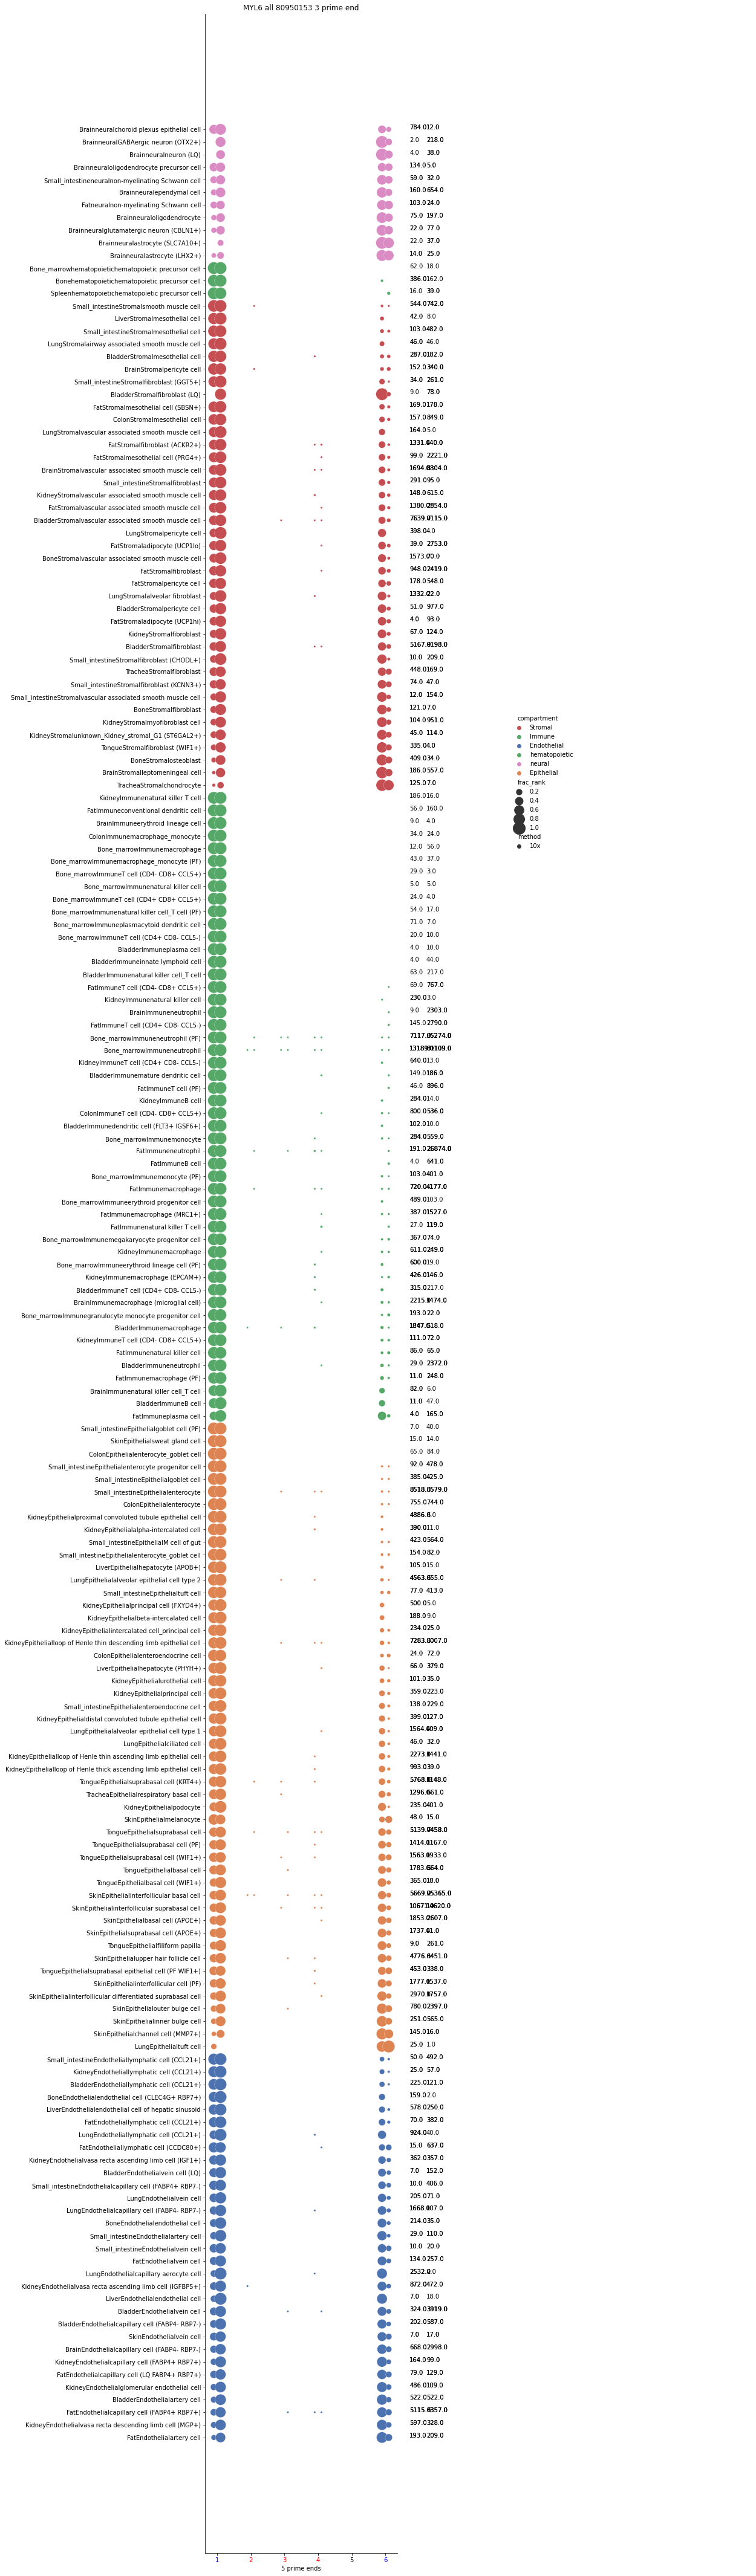

2it [01:36, 48.41s/it]


In [16]:

num_ont_comp_limit = 50

for index, row in tqdm(param_df.iterrows()):
    try:

#        print("outpath",outpath + gene + "/")
      gene = row["gene"]
      print("gene",gene)
      if not os.path.exists(outpath + gene + "/"):
          os.makedirs(outpath + gene + "/")

      let = row["let"]
      end = row["end"]
  #  gene = "MYL6"
  #  end = 56160320
  #  let = "A"
      gene_dfs = {}
      # palette = {"Endothelial" : u'#1f77b4', "Stromal" : u'#ff7f0e', "Epithelial" : u'#2ca02c', "Immune" : u'#d62728'}
#        palette = compartment_colors()


      for dataname in datanames:


        print(dataname)
#          print("end",end,"gene",gene)
#          print(df_dict[dataname][df_dict[dataname]["geneR1A_uniq"] == gene]["juncPosR1" + let].value_counts().head())
#          end2 = df_dict[dataname][df_dict[dataname]["geneR1A_uniq"] == gene]["juncPosR1" + let].value_counts().index[0]
#          print("end2",end2)
#          print("end2 == end", end2 == end)
#          print("int(end2) == end",int(end2) == end)
#          print("end2 == float(end)",end2 == float(end))
#          print("try 1",df_dict[dataname][(df_dict[dataname]["geneR1A_uniq"] == gene) & (df_dict[dataname]["juncPosR1" + let] == end)].shape[0])
#          print("try 2",df_dict[dataname][(df_dict[dataname]["juncPosR1" + let] == end)].shape[0])

#          gene_df = df_dict[dataname][(df_dict[dataname]["geneR1A_uniq"] == gene)]
#          gene_df["juncPosR1" + let] = gene_df["juncPosR1" + let].astype(int)
#          print("try 3",gene_df[(gene_df["juncPosR1" + let] == end)].shape[0])

        gene_df = df_dict[dataname][(df_dict[dataname]["geneR1A_uniq"] == gene) & (df_dict[dataname]["juncPosR1" + let] == float(end))]
        print("gene df 1",dataname,end,gene_df.shape[0])

        gene_df["num_" + let_dict[let]] = gene_df["pos{}_group".format(let)].map(gene_df.groupby("pos{}_group".format(let))["pos{}_group".format(rev_dict[let])].nunique())
        gene_df = gene_df[gene_df["num_" + let_dict[let]] > 1]
        gene_df["pos{}_cell".format(let)] = gene_df["pos{}_group".format(let)] + gene_df["cell"]
        gene_df["rank_{}".format(let_dict[let])] = gene_df.groupby("pos{}_group".format(let))["juncPosR1{}".format(rev_dict[let])].rank(method="dense")
        gene_df["scaled_rank"] = gene_df["rank_" + let_dict[let]] * gene_df["numReads"]
        gene_df["num"] = gene_df["pos{}_cell".format(let)].map(gene_df.groupby("pos{}_cell".format(let))["scaled_rank"].sum())
        gene_df["denom"] = gene_df["pos{}_cell".format(let)].map(gene_df.groupby("pos{}_cell".format(let))["numReads"].sum())
        gene_df["avg_rank"] = gene_df["num"]/gene_df["denom"]
        gene_dfs[dataname] = gene_df
      ont_list = []
      for dataname, gene_df in gene_dfs.items():
        print("A")
#        print("gene_df",gene_df.shape)
        temp = plot_df(gene_df.drop_duplicates("pos{}_cell".format(let)), let, cell_lim, "", gene, dataname, let_dict, palette, rev_dict, end,"all", gene_df, comp_sort)
        if not temp is None:
          print("B")
          onts = list(temp.sort_values(["ont_rank","ont_75","ont_25","ont_max","ont_min"]).drop_duplicates("ontology")["ontology"].unique())

          onts.reverse()
          ont_list.append(set(onts))
          print("E")
          #   dot_plot(gene_df, let, let_dict, palette,onts, outpath, gene, don, "all", dataname, rev_dict)
      print("len ont list",len(ont_list))
      if len(ont_list) > 0:
        if len(ont_list) == 1:
          shared_onts = set.union(*ont_list)

        elif len(ont_list) == 2:
          print("F")
          if len(set.union(*ont_list)) < 20:
            print("1")
            shared_onts = set.union(*ont_list)
          elif len(set.intersection(*ont_list).union(ont_list[0])) < 20:
            print("2")
            shared_onts = set.intersection(*ont_list).union(ont_list[0])
          elif len(set.intersection(*ont_list).union(ont_list[1])) < 20:
            print("3")
            shared_onts = set.intersection(*ont_list).union(ont_list[1])
          else:
            print("4")
            print("ont_list",ont_list)
            shared_onts = set.intersection(*ont_list)
            print("shared_onts",len(shared_onts),shared_onts)

        elif len(ont_list) == 3:
          if len(set.union(*ont_list)) < 20:
            shared_onts = set.union(*ont_list)
          elif len(set.union(*ont_list[:2]).intersection(ont_list[2]).union(set.union(*ont_list[:2]))) < 20:
            shared_onts = set.union(*ont_list[:2]).intersection(ont_list[:3]).union(set.union(*ont_list[:2]))
          elif len(ont_list[1].intersection(ont_list[2]).union(ont_list[0])) < 20:
            shared_onts = ont_list[1].intersection(ont_list[2]).union(ont_list[0])
          elif len(set.union(ont_list[0].intersection(ont_list[1]), ont_list[1].intersection(ont_list[2]), ont_list[0].intersection(ont_list[2]))) < 20:
            shared_onts = set.union(ont_list[0].intersection(ont_list[1]), ont_list[1].intersection(ont_list[2]), ont_list[0].intersection(ont_list[2]))
          else:
            shared_onts = set.intersection(*ont_list)
        else:
          if len(set.union(*ont_list)) < 20:
            print("1")
            shared_onts = set.union(*ont_list)
          elif len(set.intersection(*ont_list).union(ont_list[0])) < 20:
            print("2")
            shared_onts = set.intersection(*ont_list).union(ont_list[0])
          elif len(set.intersection(*ont_list).union(ont_list[1])) < 20:
            print("3")
            shared_onts = set.intersection(*ont_list).union(ont_list[1])
          else:
            print("4")
            print("ont_list",ont_list)
            shared_onts = set.intersection(*ont_list[:2])
            print("shared_onts",len(shared_onts),shared_onts)


        ## change
        print("shared_onts",shared_onts)
        print("G")
        for dataname, gene_df in gene_dfs.items():
          print("H") 
          dot_plot(gene_df[gene_df["ontology"].isin(shared_onts)], let, let_dict, palette,shared_onts, outpath, gene, end, "all", dataname, rev_dict)
        count = 0
        pdfs = []
        shift = 0.2
        print("C") 

        for dataname, gene_df in gene_dfs.items():
          print("D")
          print(dataname)
# #           subset to top 50
#           compartments = gene_df["compartment"].unique()

#           for comp in compartments:
#             remove_onts = gene_df[gene_df["compartment"] == "Immune"]["ontology"].unique()[50:]
#             gene_df = gene_df[~(gene_df["ontology"].isin(remove_onts))]
          gene_df["rank_" + let_dict[let]] = gene_df["rank_" + let_dict[let]].rank(method="dense")
          tiss = "all"
          don_df = gene_df[gene_df["ontology"].isin(shared_onts)]
          don_df["ontology_rank"] = don_df["ontology"] + don_df["rank_" + let_dict[let]].astype(str)
          don_df["rank_count"] = don_df["ontology_rank"].map(don_df.groupby("ontology_rank")["numReads"].sum())


          ont_dict = {o : i for o, i in zip(onts,range(1,don_df["ontology"].nunique() + 1))}
          print("ont_dict 1",ont_dict)
          don_df["ont_num"] = don_df["ontology"].map(ont_dict)
          pdf = don_df.drop_duplicates("ontology_rank")
          pdf["rank_sum"] = pdf["ontology"].map(pdf.groupby("ontology")["rank_count"].sum())
          pdf["frac_rank"] = pdf["rank_count"] / pdf["rank_sum"]
          #  pdf["rank_sum"] = pdf["ontology"].map(pdf.groupby("ontology")["scaled_rank"].sum())
          #  pdf["scaled_rank"] = pdf["scaled_rank"] / pdf["rank_sum"]
          pdf["rank_" + let_dict[let]] = pdf["rank_" + let_dict[let]] + count * shift
          pdf["dataset"] = dataname
          pdfs.append(pdf)

          count += 1
        full_pdf = pd.concat(pdfs,axis=0)
        
        # subset half
#         full_pdf = full_pdf.iloc[::4,:]

        shared_onts1 = list(full_pdf[full_pdf["ontology"].isin(shared_onts)]["ontology1"].unique())

        print("created full pdf")
        ax = sns.relplot(x="rank_" + let_dict[let], y="ont_num", size="frac_rank",
                    sizes=(10, 400), alpha=.5, palette=palette,hue="compartment",
                    height=max(4,pdf["ontology"].nunique()*0.3), data=full_pdf)

        ### change
#         plt.yticks(range(1,don_df["ontology"].nunique() + 1),shared_onts)
        # if let == "B":
        #   don = acc
        plt.title("{}\n{} {} {} {}".format(dataname_dict.get(dataname,dataname),gene,tiss, end, let_dict[rev_dict[let]]))
        plt.xticks([1 + shift*(len(datanames) - 1)/2,2 + shift*(len(datanames) - 1)/2],[1,2])
        # plt.savefig("{}{}_{}.png".format(outpath,gene,end),bbox_inches="tight")
        plt.close()
        ont_dict = {}
  #         print(full_pdf.groupby("rank_" + let_dict[let])["frac_rank"].sum().sort_values().index[-1])

#          for i in range(len(compartments)):

        # sorting
        for ont, ont_df in full_pdf[full_pdf["rank_" + let_dict[let]] == full_pdf.groupby("rank_" + let_dict[let])["frac_rank"].sum().sort_values().index[-1]].groupby("ontology"):
          ont_dict[ont] = ont_df["frac_rank"].sum()
        onts = sorted(ont_dict, key=ont_dict.get)
        print("in dot")
        # onts = shared_onts
        count = 0
        pdfs = []
#            shared_ends = (set(gene_dfs["TSP1_10x_nopanc_with_postprocessing"]["juncPosR1" +rev_dict[let]]).intersection(set(gene_dfs["TSP2_10x_3prime_with_postprocessing"]["juncPosR1" + rev_dict[let]]))).intersection(set(gene_dfs["TSP1_SS2"]["juncPosR1" + rev_dict[let]]))
        shared_ends = set.intersection(*[set(v["juncPosR1" + rev_dict[let]].unique()) for  v in gene_dfs.values()])
#          if len(shared_ends) == 2:
#            shift = 0.4
#          else:
#            shift = 0.2
        shift = 0.2
        print("found shared ends") 

        ### change
#         ont_dict = {o : i for o, i in zip(sorted(list(shared_onts)),range(1,len(shared_onts) + 1))}
        ont_dict = {o : i for o, i in zip(sorted(shared_onts1,reverse=True),range(1,len(shared_onts) + 1))}

        print("ont_dict 2",ont_dict)

        for dataname, gene_df in gene_dfs.items():
          print("dataname",2)
        #   gene_df = gene_dfs[datanames[0]]
        #   dataname = datanames[0]
          gene_df = gene_df[gene_df["juncPosR1" + rev_dict[let]].isin(shared_ends)]
        #   gene_df = gene_df[gene_df["rank_" + let_dict[let]].isin(gene_df["rank_" + let_dict[let]].value_counts().index[:2])]
          gene_df["rank_" + let_dict[let]] = gene_df["rank_" + let_dict[let]].rank(method="dense")
          tiss = "all"
          don_df = gene_df[gene_df["ontology"].isin(shared_onts)]
          don_df["ontology_rank"] = don_df["ontology"] + don_df["rank_" + let_dict[let]].astype(str)
          don_df["rank_count"] = don_df["ontology_rank"].map(don_df.groupby("ontology_rank")["numReads"].sum())
        #   ont_dict = {o : i for o, i in zip(onts,range(1,don_df["ontology"].nunique() + 1))}
          don_df["ont_num"] = don_df["ontology"].map(ont_dict)
          pdf = don_df.drop_duplicates("ontology_rank")
          pdf["rank_sum"] = pdf["ontology"].map(pdf.groupby("ontology")["rank_count"].sum())
          pdf["frac_rank"] = pdf["rank_count"] / pdf["rank_sum"]
          #  pdf["rank_sum"] = pdf["ontology"].map(pdf.groupby("ontology")["scaled_rank"].sum())
          #  pdf["scaled_rank"] = pdf["scaled_rank"] / pdf["rank_sum"]
          pdf["rank_" + let_dict[let]] = pdf["rank_" + let_dict[let]] + count * shift
          pdf["dataset"] = dataname
          pdfs.append(pdf)
          count += 1
#        factor = 0.5
        factor = 0.32

        full_pdf = pd.concat(pdfs,axis=0)
    
  #           subset to top 50
        compartments = full_pdf["compartment"].unique()

        for comp in compartments:
          # limit length subset
          keep_onts = full_pdf[full_pdf["compartment"] == comp]["ontology"].unique()[:num_ont_comp_limit]
          full_pdf = full_pdf[(full_pdf["compartment"] != comp) | (full_pdf["ontology"].isin(keep_onts))]
        full_pdf["ontr"] = full_pdf["ontology"] + np.floor(full_pdf["rank_" + let_dict[let]]).astype(str)
        full_pdf["ont_frac_avg"] = full_pdf["ontr"].map(full_pdf.groupby("ontr")["frac_rank"].mean())

        sorted_frac_onts = (full_pdf[np.floor(full_pdf["rank_" + let_dict[let]]) == 1].drop_duplicates("ontology").sort_values(["compartment","ont_frac_avg"])["ontology"])
        ont_dict = {o : i for o, i in zip(sorted_frac_onts,range(1,full_pdf["ontology"].nunique() + 1))}
        ann_dict = pd.Series(full_pdf.splice_ann.values,index=full_pdf["rank_" + let_dict[let]]).to_dict() 
        print("ann_dict",ann_dict)
        if comp_sort:
#            full_pdf = full_pdf.sort_values("ontology1")
          #change
#           full_pdf["ont_num"] = full_pdf["ontology1"].map({k : v for k, v in zip(sorted(full_pdf["ontology1"].unique()),reversed(range(1,len(onts) +1)))})
          full_pdf["ont_num"] = full_pdf["ontology"].map(ont_dict)
        coords = full_pdf.drop_duplicates("rank_" + let_dict[let])[["rank_" + let_dict[let],"juncPosR1A","juncPosR1B"]]
        coords = coords[coords["rank_" + let_dict[let]].isin(range(1,int(coords["rank_" + let_dict[let]].max() + 1)))].sort_values("rank_" + let_dict[let])
        coords.to_csv("{}{}_{}_{}_coords.tsv".format(outpath + gene + "/","_".join(datanames),gene,end),sep="\t",index=False)
        print("wrote coords here","{}{}_{}_{}_coords.tsv".format(outpath + gene + "/","_".join(datanames),gene,end))
        try:
          annotation_plot(gtf, domains, gene, end,outpath,datanames)
          annotation_plot(gtf, domains, gene, end,outpath,datanames,plot_all=False)

          annotation_plot(gtf, domains, gene, end,outpath,datanames,zoom=False)
          annotation_plot(gtf, domains, gene, end,outpath,datanames,zoom=False,plot_all=False)
        except Exception as e:
          print("tried annotation plot",e)
        full_pdf["ontology_dataset"] = full_pdf["ontology"] + full_pdf["dataset"]
        full_pdf["method"] = "10x"
        full_pdf.loc[(full_pdf["ontology_dataset"].str.endswith("TSP2_SS2_RUN1_RUN2_cellann")) | (full_pdf["ontology_dataset"].str.endswith("TS_pilot_smartseq_with_postprocessing_nopanc_cellann")), "method"] = "ss2"

        #snail
        print("before relplot") 
        g = sns.relplot(x="rank_" + let_dict[let],style="method",markers={"10x" : "o","ss2" : "s"}, y="ont_num",size="frac_rank",
                    sizes=(10, 400), alpha=1, palette=palette,hue="compartment", 
                    height=max(4,full_pdf["ontology"].nunique()*factor),
                         aspect=(len(datanames)*len(shared_ends)/1.5)/max(4,pdf["ontology"].nunique()*factor), 
                         data=full_pdf).set_axis_labels(expand_dict[let_dict[let]] + "s","")

        # add number of cells to plot 
        ax = g.axes[0,0]

        leg = g._legend
        full_pdf["x"] = full_pdf["rank_" + let_dict[let]].max()*1.1 + (full_pdf["rank_" + let_dict[let]] % 1) * 2.5
        
        full_pdf["full_count"] = full_pdf["ontology_dataset"].map(full_pdf.groupby("ontology_dataset")["rank_count"].sum())  
        for ind, row in full_pdf.iterrows():
          ax.text(row["x"],row["ont_num"],row["full_count"])
#            ax.text(row["x"],row["ont_num"],row["num_cells"])
#            ax.text(row["rank_" + let_dict[let]], row["ont_num"], int(row["rank_count"]),horizontalalignment='center',verticalalignment='center')

        leg.set_bbox_to_anchor([1.5, 0.5])  # coordinates of lower left of bounding box 

#            for tick_label in g.ax.get_xticklabels():
#              try:
#                if float(tick_label.get_text()) in ann_dict.keys():
#                  if ann_dict[int(float(tick_label.get_text()))]:
#                    tick_label.set_color("blue")
#                  else:
#                    tick_label.set_color("red")
#              except Exception as e:
#                print(Exception)
        ontology1 = list(full_pdf.drop_duplicates("ontology1")["ontology1"])
        ontology2 = list(full_pdf.drop_duplicates("ontology1")["ontology2"])
        ontology1, ontology2 = (list(t) for t in zip(*sorted(zip(ontology1, ontology2))))
        #########################################################
        keys = []
        values = []
        for key, value in pd.Series(full_pdf.ontology.values,index=full_pdf.ont_num).to_dict().items():
          keys.append(value)
          values.append(key)
        if comp_sort:
          new_values = []
          new_keys = []
          for i in range(len(values)):
            if not np.isnan(values[i]):
              new_values.append(values[i])
              new_keys.append(keys[i])
          plt.yticks(new_values,new_keys)
        else:
          plt.yticks(range(1,len(onts) + 1),onts)


        #########################################################
    #    if let == "B":
    #      don = acc
        plt.title("{} {} {} {}".format(gene,tiss, end, expand_dict[let_dict[rev_dict[let]]]))
        plt.xticks([x + shift*(len(datanames) - 1)/2 for x in range(1,len(shared_ends) + 1)],range(1,len(shared_ends) + 1))#[1 + shift*(len(datanames) - 1)/2,2 + shift*(len(datanames) - 1)/2],[1,2])
        ax = plt.gca()
        if len(shared_ends) == 2:
          plt.xlim(.8,2.8)

        for i in range(len(ax.get_xticklabels())):
          #   try:
              x = ax.get_xticklabels()[i]
#               print("text",x.get_text(),ann_dict[int(float(x.get_text()))])
              if float(x.get_text()) in ann_dict.keys():
  #                  print("in dict",x.get_text())
  #                  print("ann dict",ann_dict[int(float(x.get_text()))])
                if ann_dict[int(float(x.get_text()))]:
  #                    print("changed blue")
                  ax.get_xticklabels()[i].set_color('blue') 
                else:
                    ax.get_xticklabels()[i].set_color('red') 

        for i in range(len(ax.get_yticklabels())):
          x = ax.get_yticklabels()[i]
          if x.get_text() in sig_onts[gene]:
            ax.get_yticklabels()[i].set_color('green')  


        for i in range(len(ax.get_yticklabels())):
          x = ax.get_yticklabels()[i]
          if x.get_text() in ss2_missed:
            ax.get_yticklabels()[i].set_color('deeppink') 

        leg.set_bbox_to_anchor([2,0.7])

        # KEEP
        
        plt.savefig("{}{}_{}_{}.png".format(outpath,gene,"_".join(datanames),end),bbox_inches="tight")
        print("{}{}_{}_{}.png".format(outpath,gene,"_".join(datanames),end))
#         print("saved at","{}{}_{}_{}_{}.png".format(outpath + gene + "/","_".join(datanames,cell_lim),gene,end))
        plt.show()
        plt.close()

    except Exception as e:
      print(e)